##### Import Libraries

In [704]:
import numpy as np
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
from datetime import date
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import yfinance as yf

# Handling warnings
import warnings

# Suppress only specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('mode.chained_assignment', None) # Suppresses the warning

In [705]:
# HP Filter Trend function
def hpfilter_trend_cycling(data, col, lamb, return_cycle_trend=False):
    # Tuple unpacking for charge_offs
    cycle, trend = hpfilter(data[col], lamb=lamb)
    data['{}_trend_lambda_{}'.format(col, lamb)] = trend
    # Calculate error bands using the cyclical component
    cycle_std = cycle.std()
    trend_upper = trend + (cycle_std * 1.96)
    trend_lower = trend - (cycle_std * 1.96)

    data['{}_trend_lambda_{}_upper'.format(col, lamb)] = trend_upper
    data['{}_trend_lambda_{}_lower'.format(col, lamb)] = trend_lower

    if return_cycle_trend == True:
        return data, cycle, trend
    else: 
        return data

In [706]:
def plot_lambda(data, col, yticks, colors, title, ylabel):

    # Plot Credit Spread Data
    fig, ax = plt.subplots(figsize=(16,8))


    plt.plot(data.index, data['{}'.format(col)], linewidth=2, color='Blue', label="{}".format(ylabel))

    plt.plot(data.index, data['{}_trend_lambda_1000'.format(col)], linewidth=2, color = colors[0], linestyle = '--', label='Lambda 1000')
    plt.plot(data.index, data['{}_trend_lambda_4400'.format(col)], linewidth=2, color = colors[1], linestyle = '--', label='Lambda 4400')
    plt.plot(data.index, data['{}_trend_lambda_6400'.format(col)], linewidth=2, color = colors[2], linestyle = '--', label='Lambda 6400')
    plt.plot(data.index, data['{}_trend_lambda_14400'.format(col)], linewidth=2, color = colors[2], linestyle = '--', label='Lambda 14400')
    plt.plot(data.index, data['{}_trend_lambda_129600'.format(col)], linewidth=2, color = colors[2], linestyle = '--', label='Lambda 129600')

    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks, fontsize=12)
    ax.tick_params(axis='x', size=12)

    # Position legend between title and plot
    plt.title(title, size=16, fontweight='bold', pad=34)  # Add pad for spacing
    plt.legend(bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=6, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(min(yticks)-(min(yticks)*.05), max(yticks))
    plt.show();

In [707]:
def plot_best_lambda(data, col, lamb, yticks, colors, title, ylabel):

    # Plot Credit Spread Data
    fig, ax = plt.subplots(figsize=(16,8))


    plt.plot(data.index, data['{}'.format(col)], linewidth=2, color='Blue', label="{}".format(ylabel))

    plt.plot(data.index, data['{}_trend_lambda_{}'.format(col, lamb)], linewidth=2, color = colors[0], linestyle = '--', label='Lambda {}'.format(lamb))

    ax.plot(data.index, data['{}_trend_lambda_{}_upper'.format(col, lamb)], color='lightcoral', alpha=0.5, lw=1)
    ax.plot(data.index, data['{}_trend_lambda_{}_lower'.format(col, lamb)], color='lightcoral', alpha=0.5, lw=1)
    ax.fill_between(data.index.values, data['{}_trend_lambda_{}_lower'.format(col, lamb)], data['{}_trend_lambda_{}_upper'.format(col, lamb)], facecolor='lightcoral', alpha=0.3, label='95% CI')

    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks, fontsize=12)
    ax.tick_params(axis='x', size=12)

    # Position legend between title and plot
    plt.title(title, size=16, fontweight='bold', pad=34)  # Add pad for spacing
    plt.legend(bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=6, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(min(yticks)-(min(yticks)*.05), max(yticks))
    plt.show();


##### Stationary Data Set

In [708]:
# Base stationary series
np.random.seed(42)  # For reproducibility
n_periods = 100  # 5 years monthly
base_series = np.random.normal(0, 1, n_periods)  # Mean-reverting around 0

# Add some autocorrelation to make it more realistic
for i in range(1, len(base_series)):
    base_series[i] = 0.3 * base_series[i-1] + 0.7 * base_series[i]

# Scale to realistic financial metric (maybe credit spreads in basis points)
stationary_data = 250 + base_series * 50  # Mean of 250bp, std ~50bp

# Inject extremes at specific periods
extreme_periods = [15, 32, 65]  # Month 15, 32, 45
extreme_values = [450, 100, 380]  # Spike up, crash down, spike up

for period, value in zip(extreme_periods, extreme_values):
    stationary_data[period] = value

In [709]:
# create a set of month-end dates

# Define the start and end dates for your range
end_date = date(2025, 6, 30)
start_date = end_date-relativedelta(months=99)

# Generate the range of month-end dates
# The 'M' frequency alias specifies month-end dates
month_end_dates = pd.date_range(start=start_date, end=end_date, freq='ME')


In [710]:
stationary = pd.DataFrame()
stationary['data'] = stationary_data
stationary['me_dates'] = month_end_dates
stationary = stationary.set_index('me_dates')

In [711]:
lambda_values = [1000, 4400, 6400, 14400, 129600]

for i in lambda_values:
    stationary = hpfilter_trend_cycling(stationary, 'data', i)


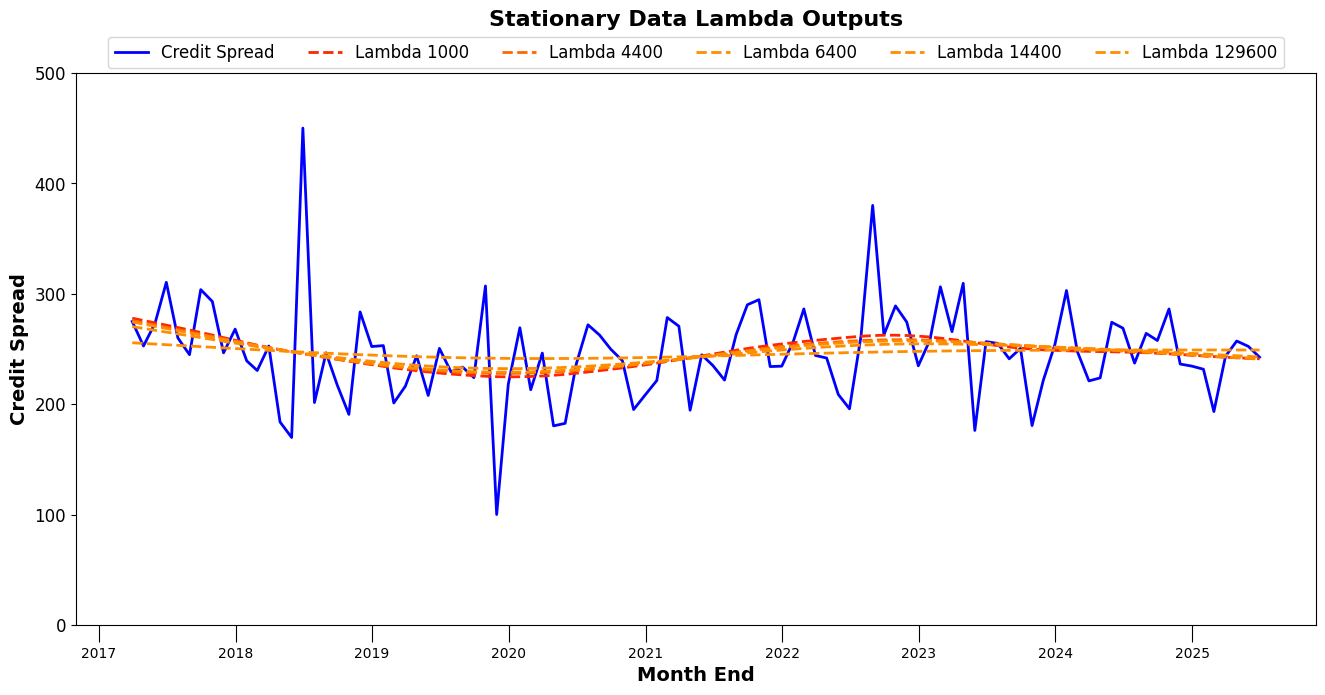

In [712]:
# Plot Ccomponents
title = "Stationary Data Lambda Outputs"
yticks = [0, 100, 200, 300, 400, 500]
colors= ["#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_lambda(stationary, 'data', yticks, colors, title, 'Credit Spread')

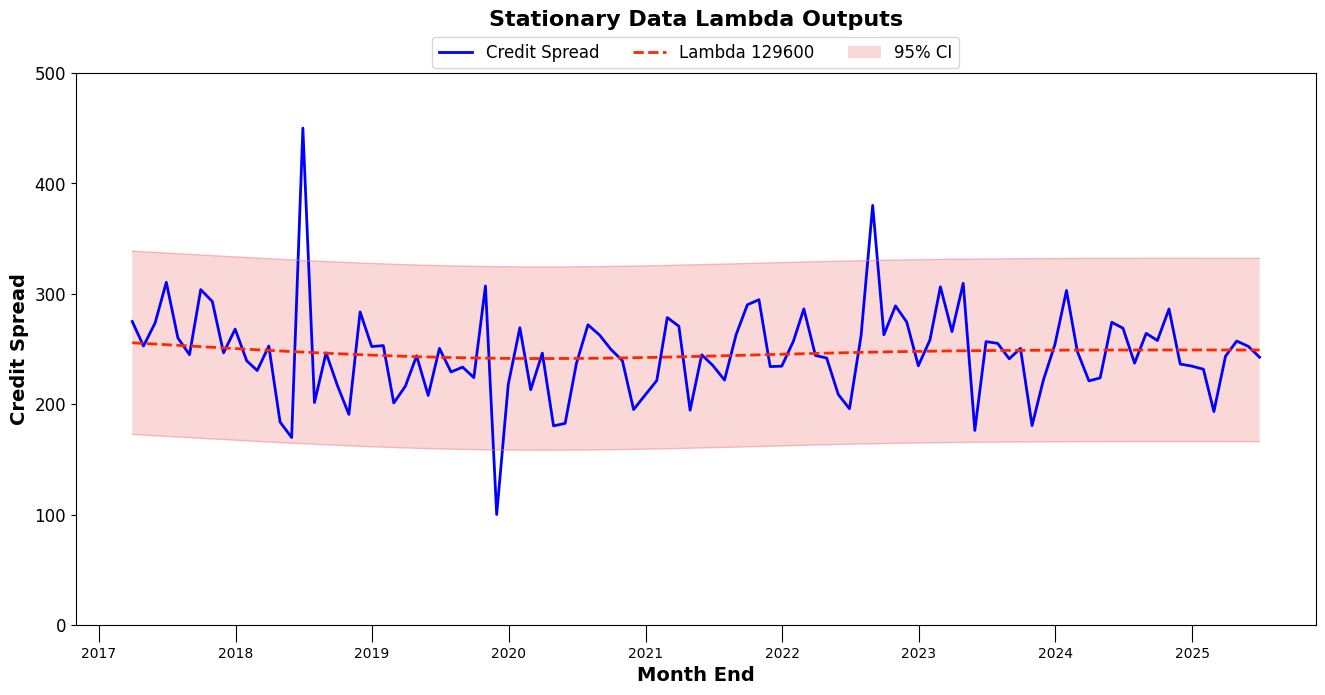

In [713]:
plot_best_lambda(stationary, 'data', 129600, yticks, colors, title, 'Credit Spread')

In [714]:
outliers = len(stationary[stationary['data'] > stationary['data_trend_lambda_129600_upper']]) + len(stationary[stationary['data'] < stationary['data_trend_lambda_129600_lower']])
total = len(stationary)
breach_rate = round((outliers/total)*100, 2)
print("BREACH RATE: {}%".format(breach_rate))

BREACH RATE: 3.0%


##### stationary Data

In [715]:
# Import META data for volatility period in 2022 and 2023
meta = yf.download('META', start='2022-01-01', end='2023-08-01')
meta_prices = meta['Close']

[*********************100%***********************]  1 of 1 completed


In [716]:
trough = meta_prices

In [717]:
lambda_values = [1000, 4400, 6400, 14400, 129600]

for i in lambda_values:
    trough = hpfilter_trend_cycling(trough, 'META', i)

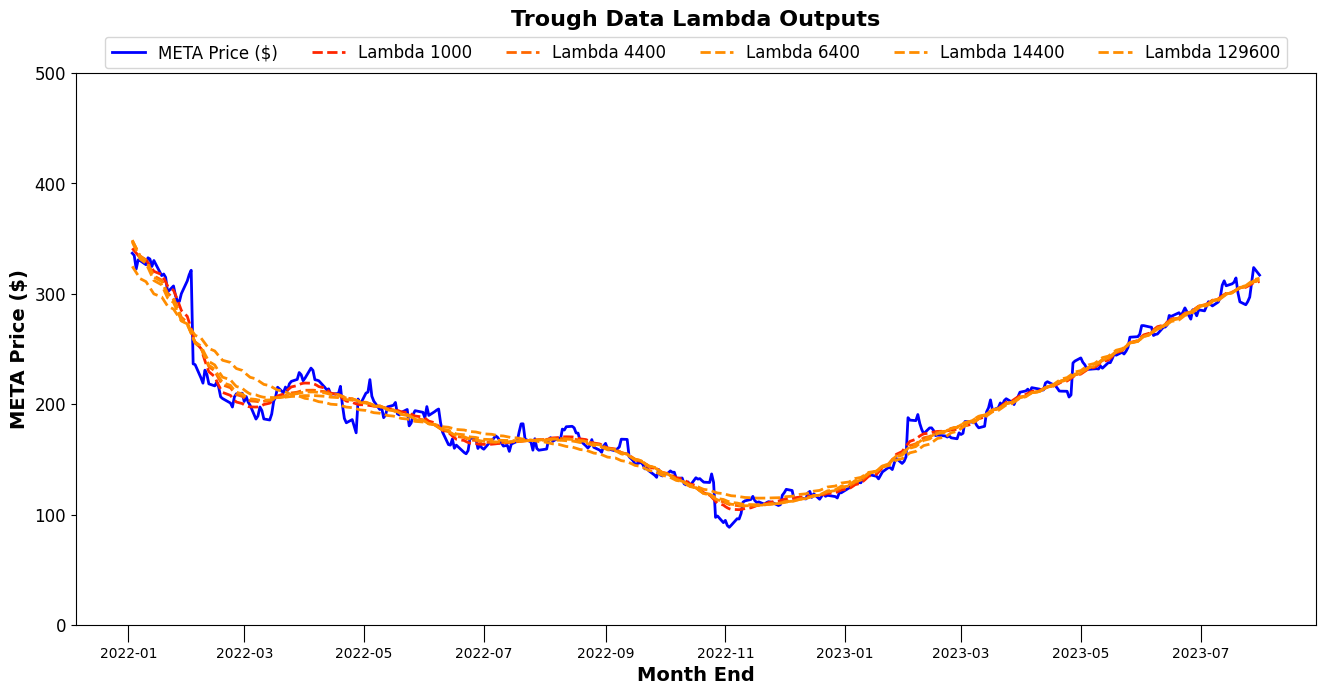

In [718]:
# Plot Ccomponents
title = "Trough Data Lambda Outputs"
yticks = [0, 100, 200, 300, 400, 500]
colors= ["#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_lambda(trough, 'META', yticks, colors, title, 'META Price ($)')

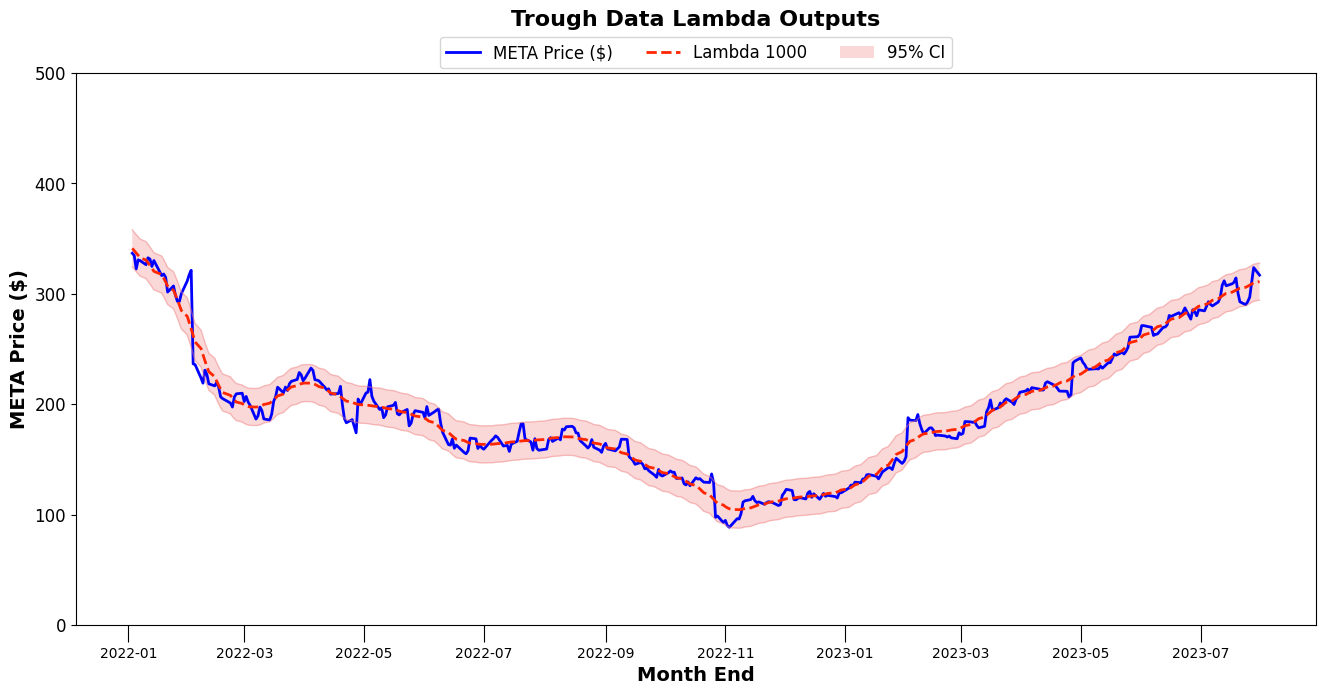

In [719]:
plot_best_lambda(trough, 'META', 1000, yticks, colors, title, 'META Price ($)')

In [720]:
outliers = len(trough[trough['META'] > trough['META_trend_lambda_1000_upper']]) + len(trough[trough['META'] < trough['META_trend_lambda_1000_lower']])
total = len(trough)
breach_rate = round((outliers/total)*100, 2)
print("BREACH RATE: {}%".format(breach_rate))

BREACH RATE: 4.56%


##### Growth Data

In [721]:
# Parameters
n_periods = 78  # 5 years monthly
growth_rate = 0.005  # 3% monthly growth
np.random.seed(42)

# Generate base exponential growth
time = np.arange(n_periods)
base_growth = 1000000 * np.exp(growth_rate * time)

# Add realistic noise (proportional to level - heteroskedastic)
noise_factor = 0.02  # 15% volatility
noise = np.random.normal(0, noise_factor, n_periods)
exponential_data = base_growth * (1 + noise)

In [722]:
# create a set of month-end dates

# Define the start and end dates for your range
end_date = date(2025, 6, 30)
start_date = end_date-relativedelta(months=77)

# Generate the range of month-end dates
# The 'M' frequency alias specifies month-end dates
month_end_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

In [723]:
growth = pd.DataFrame()
growth['data'] = exponential_data
growth['me_dates'] = month_end_dates
growth = growth.set_index('me_dates')

In [724]:
lambda_values = [1000, 4400, 6400, 14400, 129600]

for i in lambda_values:
    trough = hpfilter_trend_cycling(growth, 'data', i)

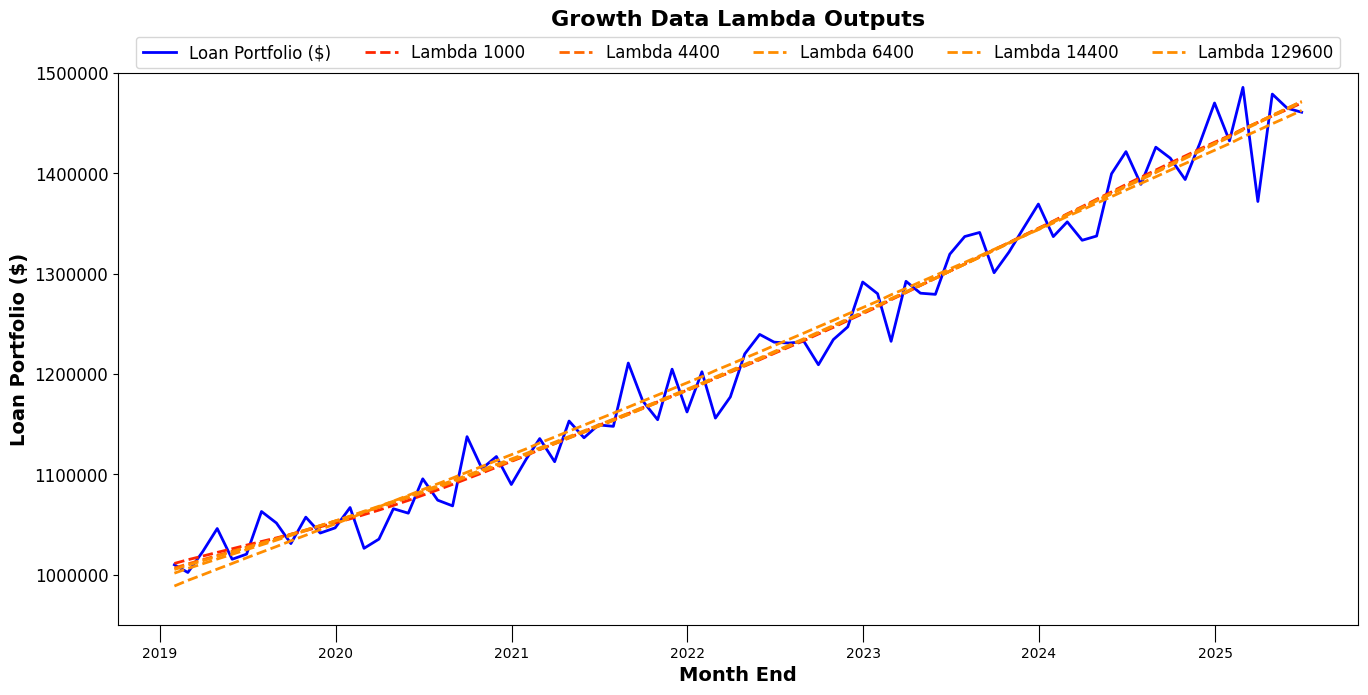

In [725]:
# Plot Ccomponents
title = "Growth Data Lambda Outputs"
yticks = [1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
colors= ["#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_lambda(growth, 'data', yticks, colors, title, 'Loan Portfolio ($)')

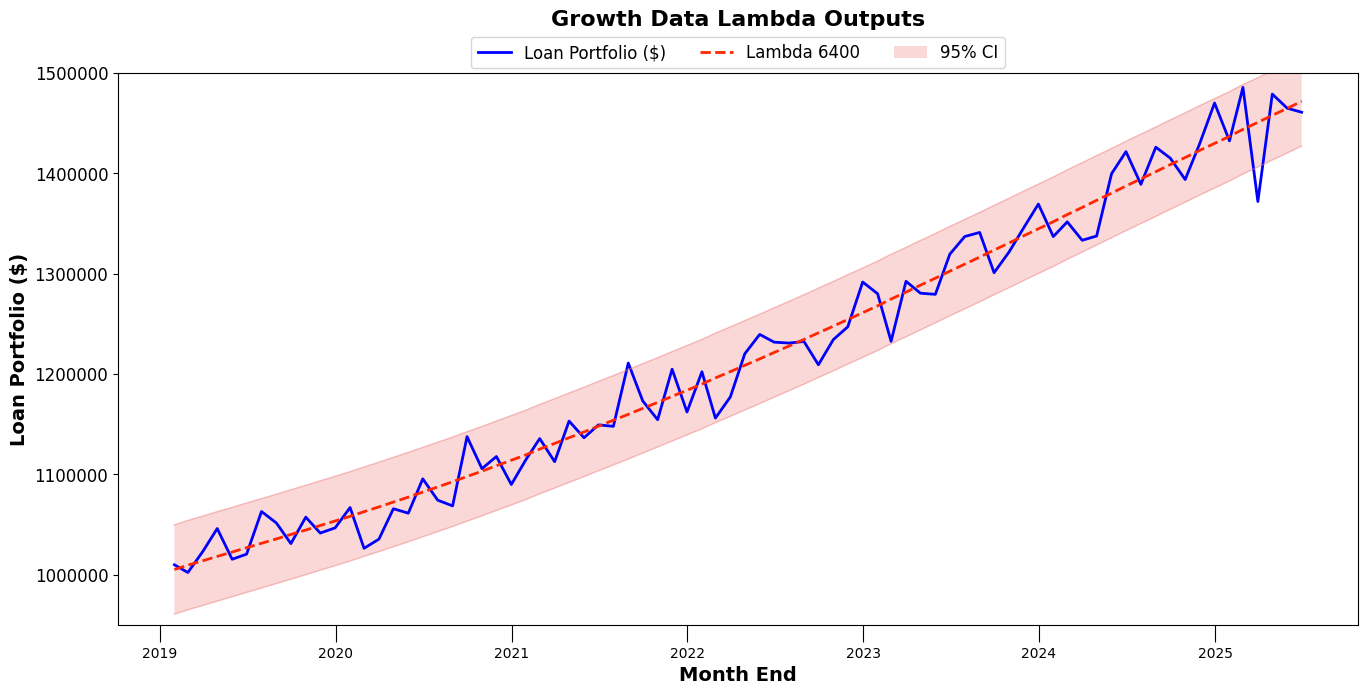

In [726]:
plot_best_lambda(growth, 'data', 6400, yticks, colors, title, 'Loan Portfolio ($)')

In [727]:
outliers = len(growth[growth['data'] > growth['data_trend_lambda_6400_upper']]) + len(growth[growth['data'] < growth['data_trend_lambda_6400_lower']])
total = len(growth)
breach_rate = round((outliers/total)*100, 2)
print("BREACH RATE: {}%".format(breach_rate))

BREACH RATE: 2.56%
